# Прогнозирование вероятности оттока пользователей для фитнес-центров #

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. 

Необходимо провести анализ и подготовить план действий по удержанию клиентов,а именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-просмотр-данных" data-toc-modified-id="Загрузка-и-просмотр-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и просмотр данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

## Загрузка и просмотр данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
import plotly.express as px

In [2]:
# чтение файла с данными и сохранение в переменную datd
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# получение общей информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

<b>Вывод</b>

Данные содержат информацию о 4000 клиентов фитнес-клуба. 

**Структура данных включает в себя:**

1) данные клиента за предыдущий до проверки факта оттока месяц:
* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)

2) информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.


* Churn — факт оттока в текущем месяце.

## Исследовательский анализ данных

In [4]:
# проверка на наличие пропусков
data.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [5]:
# проверка на наличие дубликатов
data.duplicated().sum()

0

In [6]:
# приведение столбцов к нижнему регистру
data.columns = data.columns.str.lower()

В данных отсутствуют пропуски и дубликаты.

In [7]:
round(data.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [8]:
# средние значения признаков в 2 группах (те, кто ушел и те, кто остался)
round(data.groupby('churn').mean().T, 2)

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


In [9]:
# разделим признаки на количественные и категориальные
count = ['age', 'lifetime', 'contract_period', 'month_to_end_contract', 'avg_class_frequency_total',\
         'avg_class_frequency_current_month', 'avg_additional_charges_total']
category = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

Построим столбчатые гистограммы и распределения признаков для тех, кто ушел и тех, кто остался.

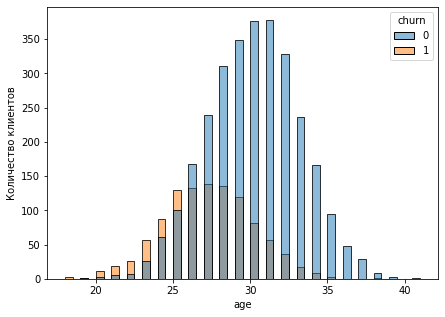

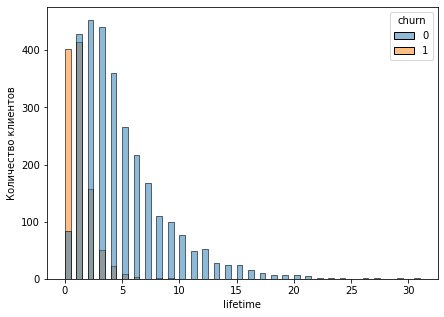

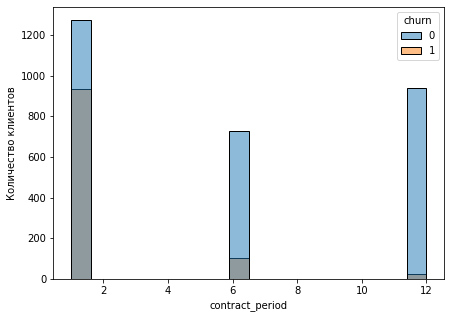

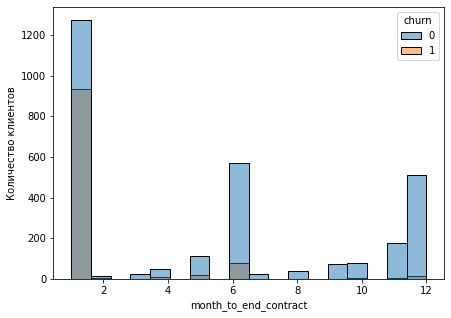

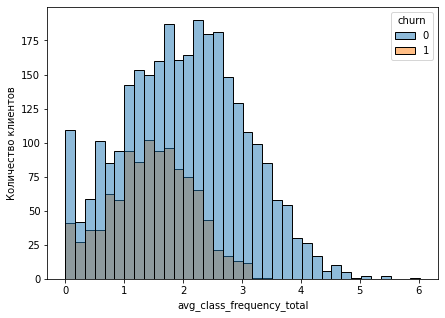

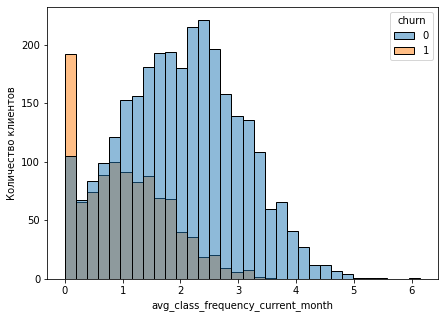

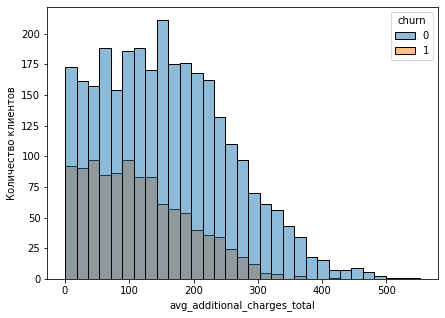

In [10]:
for col in count:
    plt.figure(figsize=(7, 5))
    sns.histplot(data=data, x=col, hue='churn')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.show()

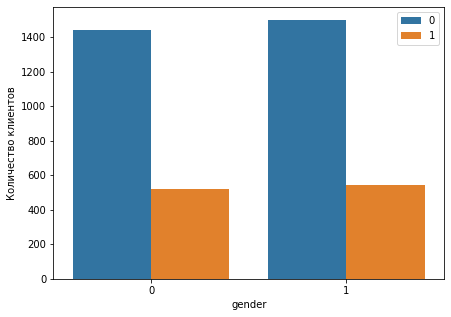

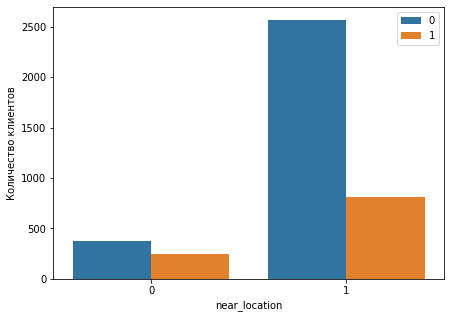

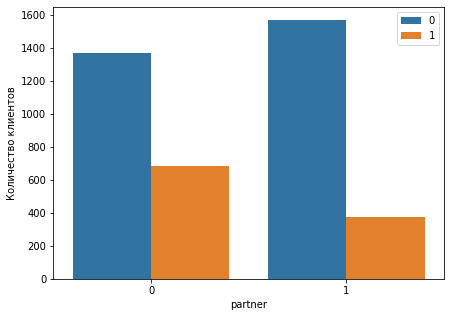

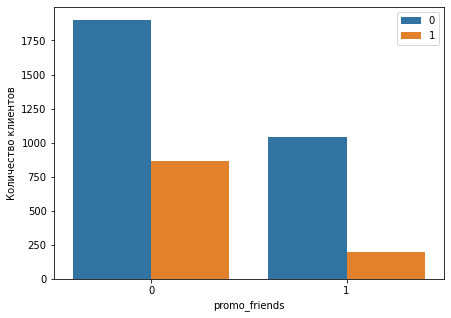

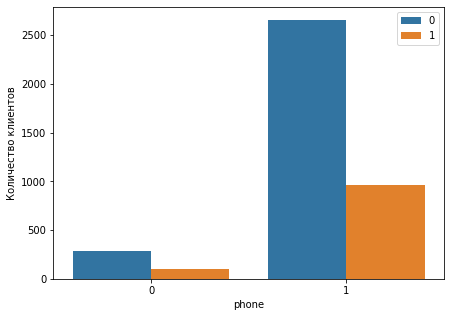

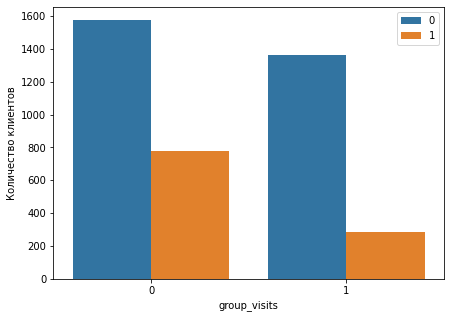

In [11]:
for col in category:
    plt.figure(figsize=(7, 5))
    sns.countplot(data=data, x=col, hue="churn")
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.legend(data['churn'].unique())
    plt.show()

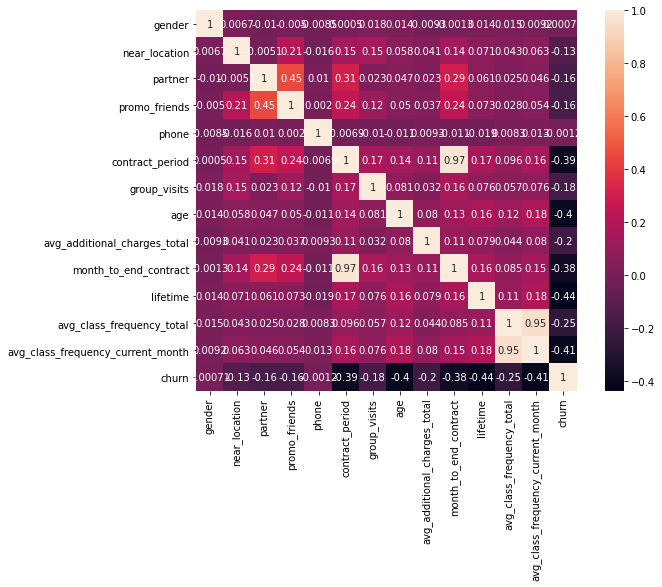

In [12]:
# построим матрицу корреляции 
corr_m = data.corr()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(corr_m, square = True, annot = True)
plt.show()

<b>Вывод</b>

Проведя анализ основных признаков, влияющих на отток пользователей, можно выделить следующее:
* соотношение полов составляет примерно 50/50;
* 85% клиентов проживают или работают в районе, где находятся фитнес-центры;
* примерно половина клиентов являются сотрудниками компании-партнера клуба;
* 30% клиентов использовали промо-код при оплате 1-го абонемента;
* средний возраст клиентов составляет около 30 лет;
* средняя частота посещений фитнес-центров - примерно 2 раз в неделю;
* чуть более 40% клиентов посещают групповые занятия;
* отток клиентов в среднем составляет 27%.

Средние значения в обеих группах (тех, кто ушел и тех, кто остался) показывают, что: 
* распределение по полу в обеих группах не отличается;
* клиенты, живущие или работающие рядом с фитнес-центором, а также являющиеся сотрудниками компании-партнера клуба реже уходят в отток;
* клиенты, пришедшие по акции "Приведи друга",  примерно в два раза реже перестают посещать фитнес-клуб;
* клиенты, ушедшие в отток, чаще всего брали абонемент на 1-2 месяца;
* средний возраст в обеих группах - до 30 лет;
* оставшиеся клиенты чаще ходят на групповые занятия;
* средняя частота посещений в обеих группах стоставяет 2 раза в неделю.

Сильно коррелируют между собой следующие признаки:
* срок до окончания текущего действующего обанемента и длительность текущего действующего абонемента;
* средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента.

Ни один из признаков сильно не влияет на отток.

## Построение модели прогнозирования оттока клиентов

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1) 
y = data['churn']
# разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [14]:
#Код ревьюера
print(X_train.shape, X_test.shape)

(3200, 13) (800, 13)


Выборки разделены корректно

**Модель логистической регрессии**

In [15]:
# зададим алгоритм для нашей модели
lg_model = LogisticRegression(solver='liblinear', random_state = 0)
# обучим модель
lg_model.fit(X_train, y_train)
# сделаем прогноз обученной модели
predictions = lg_model.predict(X_test)
# выведем значения метрик на валидационной выборке
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Точность: {:.2f}'.format(precision_score(y_test, predictions)))
print('Полнота: {:.2f}'.format(recall_score(y_test, predictions)))

Доля правильных ответов: 0.93
Точность: 0.86
Полнота: 0.83


**Модель случайного леса**

In [16]:
# зададим алгоритм для нашей модели
rf_model = RandomForestClassifier(random_state=0)
# обучим модель
rf_model.fit(X_train, y_train)
# сделаем прогноз обученной модели
predictions = rf_model.predict(X_test)
# выведем значения метрик на валидационной выборке
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Точность: {:.2f}'.format(precision_score(y_test, predictions)))
print('Полнота: {:.2f}'.format(recall_score(y_test, predictions)))

Доля правильных ответов: 0.92
Точность: 0.84
Полнота: 0.82


<b>Вывод</b>

Мы построили модель бинарной классификации клиентов, где целевой признак - факт оттока клиентов в следующем месяце. Обучили модель двумя способами - логистической регрессией и случайным лесом. 

На основании полученных метрик лучше себя показала модель логистической регрессии.

## Кластеризация клиентов

In [17]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

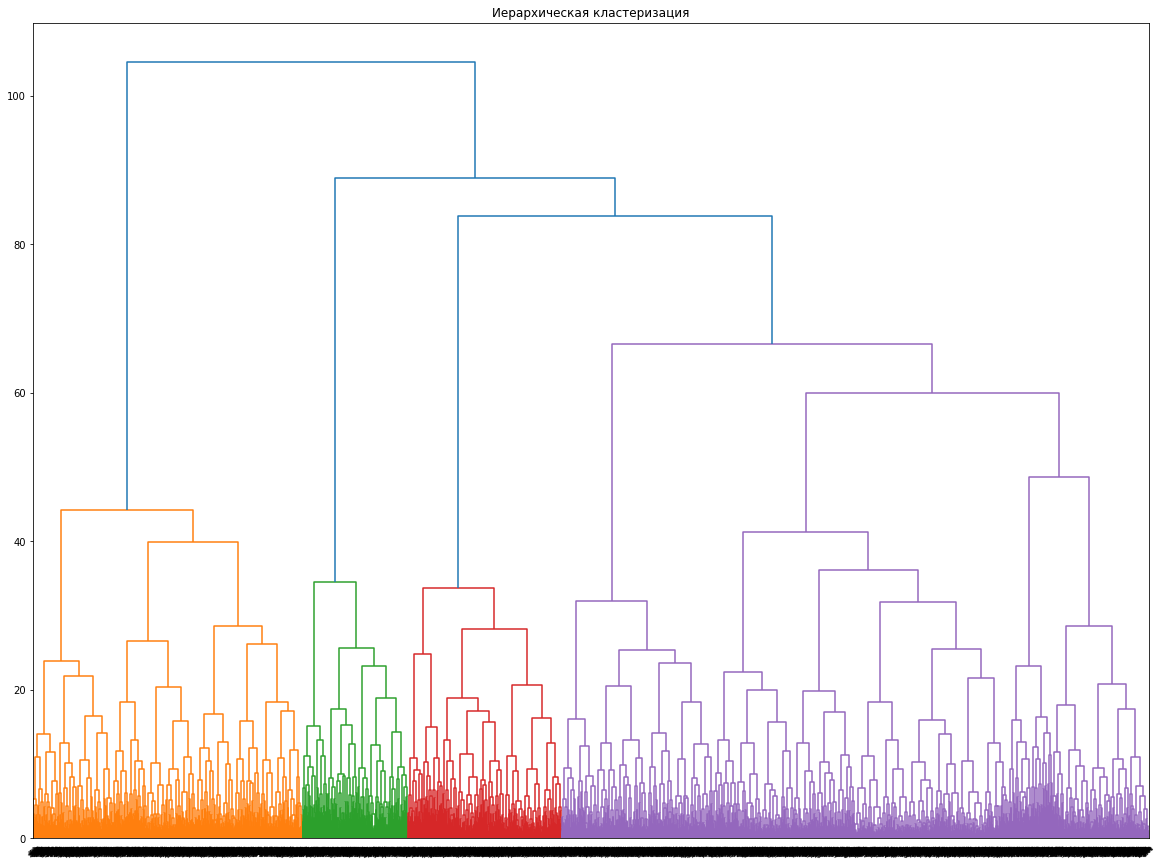

In [18]:
# построим дендрограмму 
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(20, 15))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.xticks(rotation=45)
plt.show()

**Обучим модель кластеризации на основании алгоритма К-Means и спрогнозируем кластеры клиентов**

In [19]:
# зададим модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# спрогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc) 
# сохраним метки кластера в поле датасета
data['cluster'] = labels

In [20]:
# выведем количество клиентов в каждом кластере
print(data['cluster'].value_counts())

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64


In [21]:
# выведем статистику по средним значениям наших признаков по кластеру
round(data.groupby(['cluster']).mean().T, 2)

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


In [22]:
# посчитаем долю оттока для каждого кластера
data.groupby('cluster')['churn'].mean().sort_values(ascending=False)

cluster
3    0.514263
2    0.443564
1    0.267532
4    0.068019
0    0.027723
Name: churn, dtype: float64

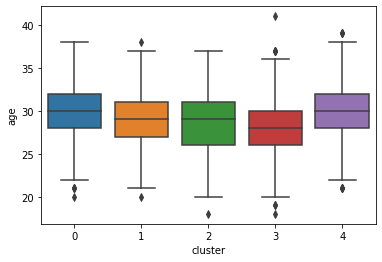

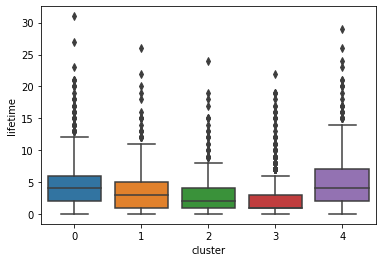

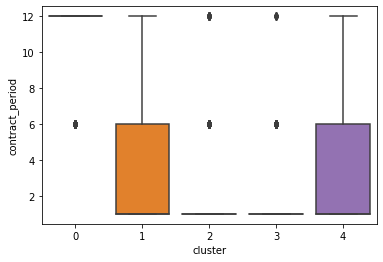

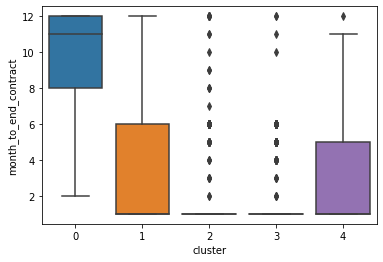

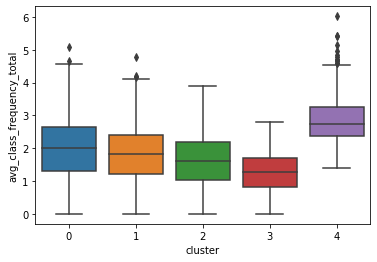

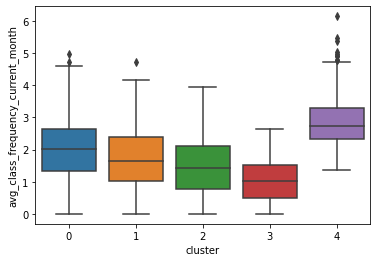

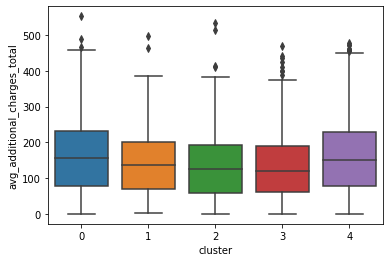

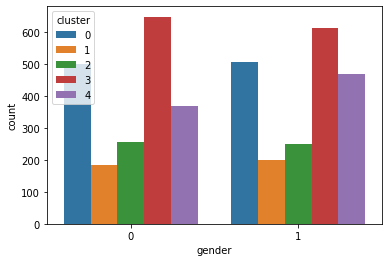

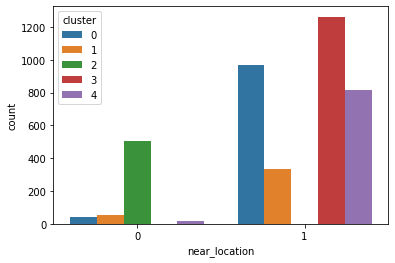

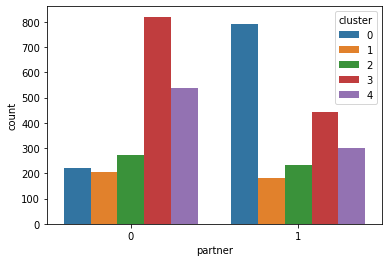

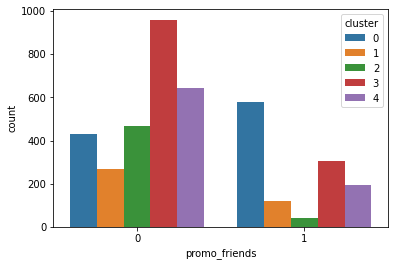

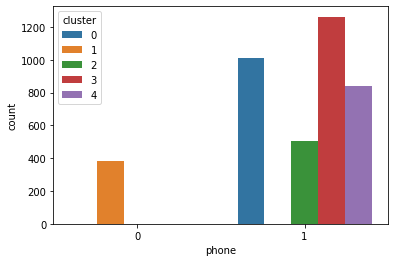

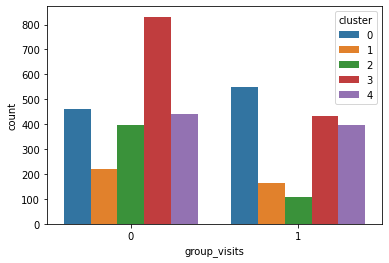

In [23]:
# построим графики распределения признаков для кластеров
for col in count:
    sns.boxplot(x ='cluster', y = col, data = data)
    plt.show()
for col in category:
    sns.countplot(x = col, hue = 'cluster', data = data)
    plt.show()

<b/>Вывод</b>

Мы стандартизировали данные и построили дендрограмму. На основании полученной дендрограммы можно выделить 4 кластера клиентов.

Используя алгоритм К-Means, мы разделили клиентов фитнес-клуба на 5 кластеров. 

Количество клиентов в каждом кластере:
* 0  - 1010
* 1  - 385
* 2  - 505
* 3  - 1262
* 4  - 838

Средний возраст клиентов всех кластеров составляет 28-30 лет. Распределение полов по всем группам примерно одинаковое.

Наиболее надежными выглядят кластеры 0 и 4. Клиенты данных кластеров живут/работают недалеко от фитнес-центров, средняя частота посещений составляет 2-3 раза в неделю, они чаще других посещают групповые занятия и покупают дополнительные услуги фитнес-центров.

Максимальная доля оттока наблюдается по кластерам 3 и 2 и составляет 51% и 44% соответственно. Клиенты этих кластеров покупают абонементы на более короткий период, реже ходят на тренировки и посещают групповые занятия, меньше покупают дополнительные услуги.

## Выводы и рекомендации

<b>Выводы</b>

* Нами был проведен анализ анкет 4000 клиентов фитнес-клуба. Данные были представлены в полном объеме, в них отсутствовали пропуски и дубликаты


* Анализ средних значений признаков по 2 группам (тех, кто ушел в отток и тех, кто остался) показал, что реже уходят в отток те клиенты, которые:
    * живут/работают рядом с фитнес центром,
    * являются сотрудниками компании-партнера клуба,
    * посещают занятия в фитнес-клубе 2 раза в неделю,
    * чаще ходят на групповые занятия,
    * при оплате первого абонемента использовали промо-код "Приведи друга"
    
    
* Мы построили модель бинарной классификации клиентов, где целевой признак - факт оттока клиентов в следующем месяце. Обучили модель двумя способами - логистической регрессией и случайным лесом. На основании полученных метрик лучше себя показала модель логистической регрессии


* Стандартизировали данные, построили дендрограмму, на основании которой выделили 4 кластера клиентов


* Обучили модель кластеризации на основании алгоритма К-Меаns и спрогнозировали кластеры клиентов


* Наиболее склонны к оттоку кластеры под номерами 3 и 2, их доля сотавляет 51% и 44% соответсвенно. Средние значения признаков говорят нам о том, что клиенты этих кластеров покупают абонементы на более короткий период, реже ходят на тренировки и групповые занятия, меньше покупают дополнительные услуги


* Наиболее надежными выглядят кластеры 0 и 4. Клиенты данных кластеров живут/работают недалеко от фитнес-центров, средняя частота посещений составляет 2-3 раза в неделю, они чаще других посещают групповые занятия и покупают дополнительные услуги фитнес-центров

<b>Рекомендации</b>

* расширить список компаний-партнеров клуба


* разработать систему скидок при покупке абонемента на длительный период (6, 12 месяцев) и дополнительные услуги фитнес-клуба


* расширение видов групповых занятий


* предоставление бесплатной (ознакомительной) индивидуальной тренировки в тренажерном зале